# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

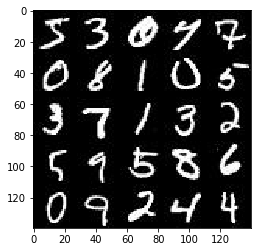

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

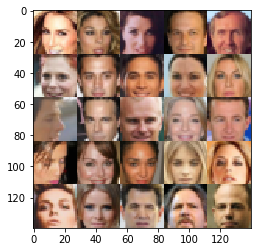

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
     
        # 28->14->7->3.5  doesn't work
        # opt1=[28,14,7,7]
        # opt2=[28,14,14,7]
        # opt3=[28,28,14,7]
        x=images
        alpha=0.2 # Mat uses 0.2 in DCGAN

        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # is_train = True -> reuse->False
    # is_train = False -> reuse->True

    alpha=0.2 # Mat uses 0.2 in DCGAN
        
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # 7x7x512 now
    
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
    
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
    
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
    
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    image_width=data_shape[1]
    image_height=data_shape[2]
    image_channels=data_shape[3]
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []    

    print_every=25
    show_every=100
    batches = mnist_dataset.shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_i, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model

                #The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.
                batch_images = batch_images*2.0  # rescale to -1, 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     input_real: batch_images,
                                                     learn_rate: learning_rate})

                if (batch_i+1) % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batches {}/{}...".format(batch_i+1, batches),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if (batch_i+1) % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
        
    return losses, samples              

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batches 25/1500... Discriminator Loss: 0.7134... Generator Loss: 1.2582
Epoch 1/2... Batches 50/1500... Discriminator Loss: 0.8000... Generator Loss: 0.9357
Epoch 1/2... Batches 75/1500... Discriminator Loss: 0.5478... Generator Loss: 1.9003
Epoch 1/2... Batches 100/1500... Discriminator Loss: 1.0150... Generator Loss: 0.6469


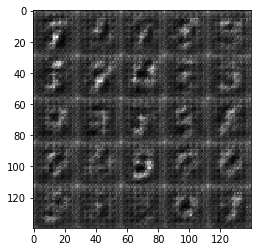

Epoch 1/2... Batches 125/1500... Discriminator Loss: 1.0511... Generator Loss: 0.6587
Epoch 1/2... Batches 150/1500... Discriminator Loss: 0.5543... Generator Loss: 1.7652
Epoch 1/2... Batches 175/1500... Discriminator Loss: 0.6700... Generator Loss: 1.3297
Epoch 1/2... Batches 200/1500... Discriminator Loss: 0.8832... Generator Loss: 0.7769


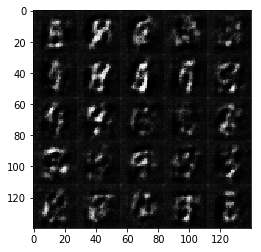

Epoch 1/2... Batches 225/1500... Discriminator Loss: 0.5941... Generator Loss: 2.8224
Epoch 1/2... Batches 250/1500... Discriminator Loss: 0.7238... Generator Loss: 0.9566
Epoch 1/2... Batches 275/1500... Discriminator Loss: 0.6868... Generator Loss: 2.4902
Epoch 1/2... Batches 300/1500... Discriminator Loss: 1.5283... Generator Loss: 0.4424


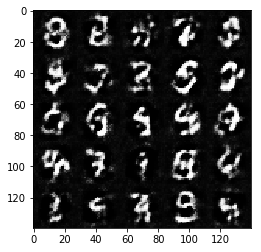

Epoch 1/2... Batches 325/1500... Discriminator Loss: 0.4328... Generator Loss: 1.4784
Epoch 1/2... Batches 350/1500... Discriminator Loss: 1.6284... Generator Loss: 0.3034
Epoch 1/2... Batches 375/1500... Discriminator Loss: 0.5014... Generator Loss: 1.4582
Epoch 1/2... Batches 400/1500... Discriminator Loss: 0.5601... Generator Loss: 1.0682


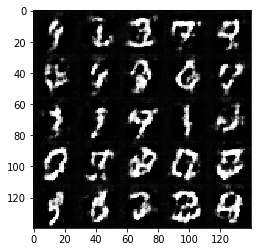

Epoch 1/2... Batches 425/1500... Discriminator Loss: 1.4065... Generator Loss: 0.3756
Epoch 1/2... Batches 450/1500... Discriminator Loss: 0.8161... Generator Loss: 0.9670
Epoch 1/2... Batches 475/1500... Discriminator Loss: 0.5722... Generator Loss: 1.4195
Epoch 1/2... Batches 500/1500... Discriminator Loss: 1.6005... Generator Loss: 0.2726


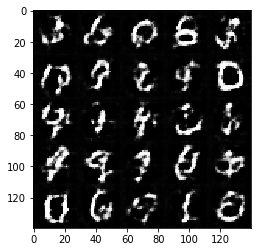

Epoch 1/2... Batches 525/1500... Discriminator Loss: 0.6519... Generator Loss: 1.3270
Epoch 1/2... Batches 550/1500... Discriminator Loss: 0.5989... Generator Loss: 1.3955
Epoch 1/2... Batches 575/1500... Discriminator Loss: 0.6153... Generator Loss: 1.7083
Epoch 1/2... Batches 600/1500... Discriminator Loss: 0.4260... Generator Loss: 2.5020


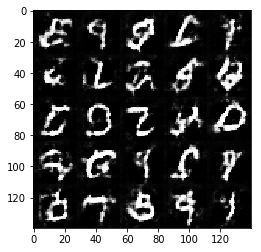

Epoch 1/2... Batches 625/1500... Discriminator Loss: 0.6111... Generator Loss: 2.7307
Epoch 1/2... Batches 650/1500... Discriminator Loss: 0.4399... Generator Loss: 1.6563
Epoch 1/2... Batches 675/1500... Discriminator Loss: 0.6858... Generator Loss: 0.9305
Epoch 1/2... Batches 700/1500... Discriminator Loss: 0.7275... Generator Loss: 0.9533


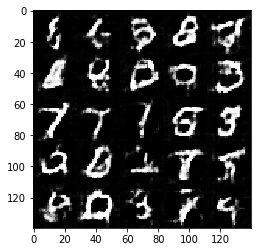

Epoch 1/2... Batches 725/1500... Discriminator Loss: 1.0363... Generator Loss: 0.5939
Epoch 1/2... Batches 750/1500... Discriminator Loss: 0.8198... Generator Loss: 0.8180
Epoch 1/2... Batches 775/1500... Discriminator Loss: 0.7195... Generator Loss: 1.0189
Epoch 1/2... Batches 800/1500... Discriminator Loss: 0.9758... Generator Loss: 0.6129


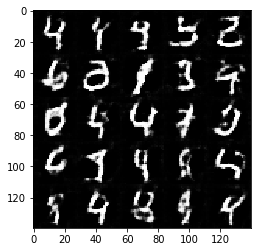

Epoch 1/2... Batches 825/1500... Discriminator Loss: 1.4255... Generator Loss: 0.6331
Epoch 1/2... Batches 850/1500... Discriminator Loss: 1.1419... Generator Loss: 0.5602
Epoch 1/2... Batches 875/1500... Discriminator Loss: 0.5976... Generator Loss: 1.1272
Epoch 1/2... Batches 900/1500... Discriminator Loss: 0.5254... Generator Loss: 1.4382


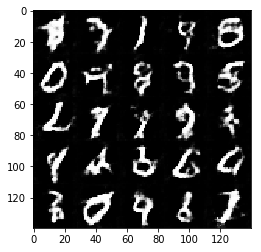

Epoch 1/2... Batches 925/1500... Discriminator Loss: 0.6225... Generator Loss: 1.1203
Epoch 1/2... Batches 950/1500... Discriminator Loss: 0.6238... Generator Loss: 1.1155
Epoch 1/2... Batches 975/1500... Discriminator Loss: 0.5648... Generator Loss: 1.9637
Epoch 1/2... Batches 1000/1500... Discriminator Loss: 0.5442... Generator Loss: 1.6778


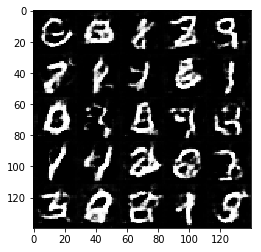

Epoch 1/2... Batches 1025/1500... Discriminator Loss: 0.6510... Generator Loss: 1.1629
Epoch 1/2... Batches 1050/1500... Discriminator Loss: 0.9937... Generator Loss: 0.7878
Epoch 1/2... Batches 1075/1500... Discriminator Loss: 1.0091... Generator Loss: 0.6397
Epoch 1/2... Batches 1100/1500... Discriminator Loss: 0.5996... Generator Loss: 1.1206


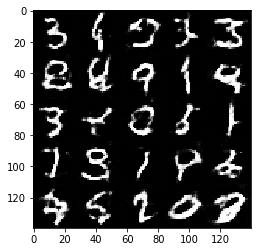

Epoch 1/2... Batches 1125/1500... Discriminator Loss: 0.4517... Generator Loss: 1.5014
Epoch 1/2... Batches 1150/1500... Discriminator Loss: 0.7678... Generator Loss: 0.8863
Epoch 1/2... Batches 1175/1500... Discriminator Loss: 1.3638... Generator Loss: 0.4180
Epoch 1/2... Batches 1200/1500... Discriminator Loss: 0.4420... Generator Loss: 1.2877


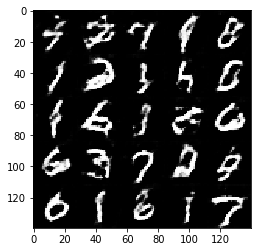

Epoch 1/2... Batches 1225/1500... Discriminator Loss: 1.0044... Generator Loss: 0.5955
Epoch 1/2... Batches 1250/1500... Discriminator Loss: 1.1617... Generator Loss: 4.4653
Epoch 1/2... Batches 1275/1500... Discriminator Loss: 0.4470... Generator Loss: 1.4503
Epoch 1/2... Batches 1300/1500... Discriminator Loss: 0.6618... Generator Loss: 0.9771


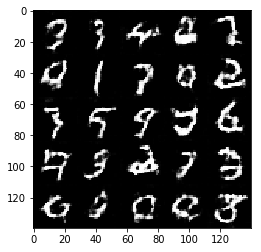

Epoch 1/2... Batches 1325/1500... Discriminator Loss: 0.6216... Generator Loss: 1.0794
Epoch 1/2... Batches 1350/1500... Discriminator Loss: 0.7594... Generator Loss: 1.8915
Epoch 1/2... Batches 1375/1500... Discriminator Loss: 0.8271... Generator Loss: 1.7336
Epoch 1/2... Batches 1400/1500... Discriminator Loss: 0.8776... Generator Loss: 0.8071


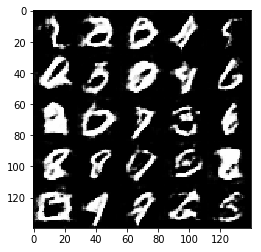

Epoch 1/2... Batches 1425/1500... Discriminator Loss: 1.4601... Generator Loss: 0.3731
Epoch 1/2... Batches 1450/1500... Discriminator Loss: 0.6793... Generator Loss: 1.0979
Epoch 1/2... Batches 1475/1500... Discriminator Loss: 0.7622... Generator Loss: 0.9851
Epoch 1/2... Batches 1500/1500... Discriminator Loss: 0.5035... Generator Loss: 1.3086


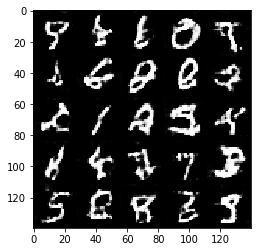

Epoch 2/2... Batches 25/1500... Discriminator Loss: 1.0111... Generator Loss: 1.2963
Epoch 2/2... Batches 50/1500... Discriminator Loss: 1.7037... Generator Loss: 0.3218
Epoch 2/2... Batches 75/1500... Discriminator Loss: 0.7006... Generator Loss: 0.8897
Epoch 2/2... Batches 100/1500... Discriminator Loss: 0.4774... Generator Loss: 1.4054


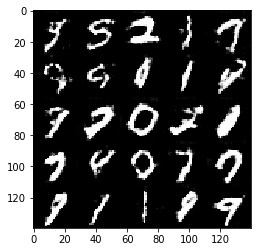

Epoch 2/2... Batches 125/1500... Discriminator Loss: 0.6301... Generator Loss: 0.9996
Epoch 2/2... Batches 150/1500... Discriminator Loss: 0.3896... Generator Loss: 1.6136
Epoch 2/2... Batches 175/1500... Discriminator Loss: 1.6835... Generator Loss: 0.4106
Epoch 2/2... Batches 200/1500... Discriminator Loss: 0.6614... Generator Loss: 0.9482


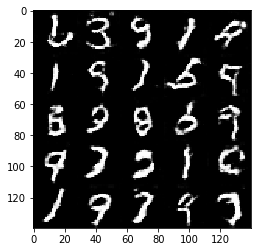

Epoch 2/2... Batches 225/1500... Discriminator Loss: 1.2190... Generator Loss: 0.5588
Epoch 2/2... Batches 250/1500... Discriminator Loss: 0.4729... Generator Loss: 1.4458
Epoch 2/2... Batches 275/1500... Discriminator Loss: 2.6521... Generator Loss: 0.1757
Epoch 2/2... Batches 300/1500... Discriminator Loss: 0.6165... Generator Loss: 1.2112


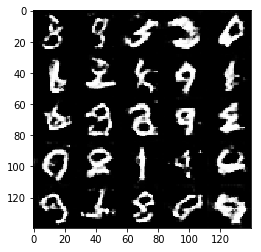

Epoch 2/2... Batches 325/1500... Discriminator Loss: 0.4887... Generator Loss: 1.2968
Epoch 2/2... Batches 350/1500... Discriminator Loss: 0.5530... Generator Loss: 1.8689
Epoch 2/2... Batches 375/1500... Discriminator Loss: 1.3589... Generator Loss: 0.4149
Epoch 2/2... Batches 400/1500... Discriminator Loss: 0.4734... Generator Loss: 1.3153


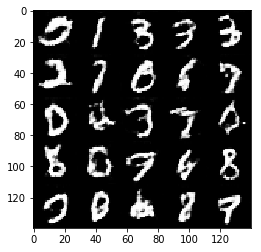

Epoch 2/2... Batches 425/1500... Discriminator Loss: 1.3600... Generator Loss: 0.4414
Epoch 2/2... Batches 450/1500... Discriminator Loss: 1.2449... Generator Loss: 0.5677
Epoch 2/2... Batches 475/1500... Discriminator Loss: 1.1277... Generator Loss: 0.5009
Epoch 2/2... Batches 500/1500... Discriminator Loss: 2.4839... Generator Loss: 0.1799


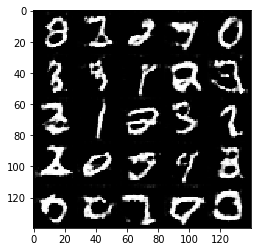

Epoch 2/2... Batches 525/1500... Discriminator Loss: 0.5535... Generator Loss: 2.5099
Epoch 2/2... Batches 550/1500... Discriminator Loss: 0.6882... Generator Loss: 1.1875
Epoch 2/2... Batches 575/1500... Discriminator Loss: 0.7171... Generator Loss: 0.9516
Epoch 2/2... Batches 600/1500... Discriminator Loss: 0.6563... Generator Loss: 1.0368


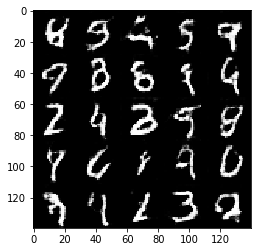

Epoch 2/2... Batches 625/1500... Discriminator Loss: 0.8783... Generator Loss: 0.7822
Epoch 2/2... Batches 650/1500... Discriminator Loss: 0.4720... Generator Loss: 1.7235
Epoch 2/2... Batches 675/1500... Discriminator Loss: 1.0432... Generator Loss: 0.7513
Epoch 2/2... Batches 700/1500... Discriminator Loss: 0.6803... Generator Loss: 0.9593


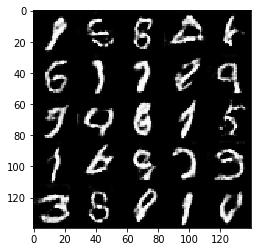

Epoch 2/2... Batches 725/1500... Discriminator Loss: 0.3514... Generator Loss: 2.1204
Epoch 2/2... Batches 750/1500... Discriminator Loss: 0.8006... Generator Loss: 0.9545
Epoch 2/2... Batches 775/1500... Discriminator Loss: 0.3916... Generator Loss: 1.7950
Epoch 2/2... Batches 800/1500... Discriminator Loss: 0.4074... Generator Loss: 1.6981


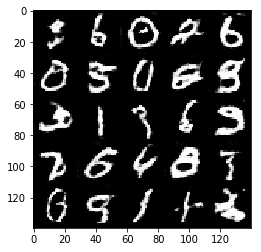

Epoch 2/2... Batches 825/1500... Discriminator Loss: 1.0799... Generator Loss: 0.6652
Epoch 2/2... Batches 850/1500... Discriminator Loss: 1.1967... Generator Loss: 0.5327
Epoch 2/2... Batches 875/1500... Discriminator Loss: 1.1871... Generator Loss: 0.4693
Epoch 2/2... Batches 900/1500... Discriminator Loss: 0.3866... Generator Loss: 1.7472


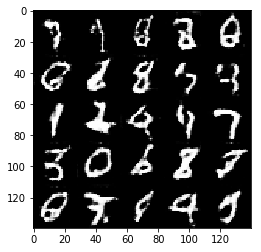

Epoch 2/2... Batches 925/1500... Discriminator Loss: 2.0293... Generator Loss: 0.2540
Epoch 2/2... Batches 950/1500... Discriminator Loss: 0.5098... Generator Loss: 1.4158
Epoch 2/2... Batches 975/1500... Discriminator Loss: 0.6098... Generator Loss: 0.9973
Epoch 2/2... Batches 1000/1500... Discriminator Loss: 0.5590... Generator Loss: 1.1993


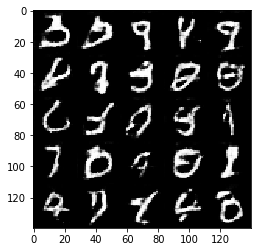

Epoch 2/2... Batches 1025/1500... Discriminator Loss: 0.4530... Generator Loss: 1.8862
Epoch 2/2... Batches 1050/1500... Discriminator Loss: 0.5659... Generator Loss: 1.4413
Epoch 2/2... Batches 1075/1500... Discriminator Loss: 0.7755... Generator Loss: 0.8745
Epoch 2/2... Batches 1100/1500... Discriminator Loss: 0.4469... Generator Loss: 1.9725


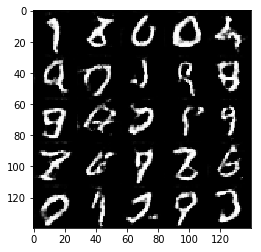

Epoch 2/2... Batches 1125/1500... Discriminator Loss: 1.1552... Generator Loss: 0.7988
Epoch 2/2... Batches 1150/1500... Discriminator Loss: 0.3152... Generator Loss: 2.6726
Epoch 2/2... Batches 1175/1500... Discriminator Loss: 0.9689... Generator Loss: 0.7417
Epoch 2/2... Batches 1200/1500... Discriminator Loss: 0.5405... Generator Loss: 1.3630


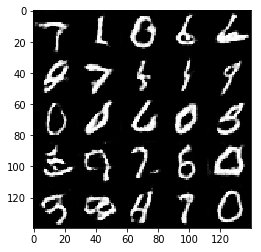

Epoch 2/2... Batches 1225/1500... Discriminator Loss: 0.7050... Generator Loss: 0.9337
Epoch 2/2... Batches 1250/1500... Discriminator Loss: 0.4725... Generator Loss: 2.1679
Epoch 2/2... Batches 1275/1500... Discriminator Loss: 0.4313... Generator Loss: 2.3492
Epoch 2/2... Batches 1300/1500... Discriminator Loss: 0.7952... Generator Loss: 4.0264


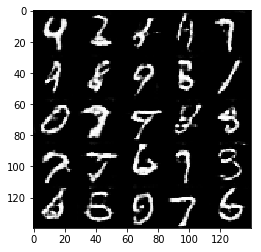

Epoch 2/2... Batches 1325/1500... Discriminator Loss: 1.2863... Generator Loss: 0.5560
Epoch 2/2... Batches 1350/1500... Discriminator Loss: 0.4251... Generator Loss: 1.8502
Epoch 2/2... Batches 1375/1500... Discriminator Loss: 2.0463... Generator Loss: 0.3570
Epoch 2/2... Batches 1400/1500... Discriminator Loss: 0.6240... Generator Loss: 2.1564


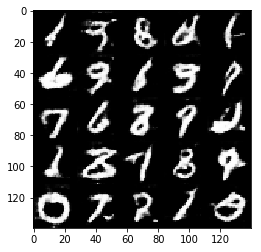

Epoch 2/2... Batches 1425/1500... Discriminator Loss: 0.6633... Generator Loss: 1.1696
Epoch 2/2... Batches 1450/1500... Discriminator Loss: 0.4635... Generator Loss: 1.7118
Epoch 2/2... Batches 1475/1500... Discriminator Loss: 0.5581... Generator Loss: 2.5665
Epoch 2/2... Batches 1500/1500... Discriminator Loss: 0.6535... Generator Loss: 1.0933


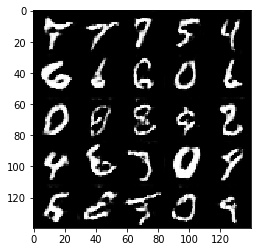

In [24]:
batch_size = 40
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batches 25/1500... Discriminator Loss: 0.1864... Generator Loss: 3.6235
Epoch 1/1... Batches 50/1500... Discriminator Loss: 0.1924... Generator Loss: 5.8534
Epoch 1/1... Batches 75/1500... Discriminator Loss: 2.7108... Generator Loss: 0.2724
Epoch 1/1... Batches 100/1500... Discriminator Loss: 0.5805... Generator Loss: 1.2279


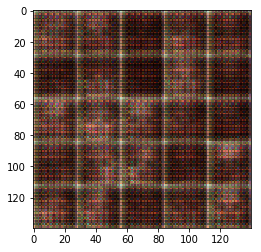

Epoch 1/1... Batches 125/1500... Discriminator Loss: 1.0035... Generator Loss: 0.6640
Epoch 1/1... Batches 150/1500... Discriminator Loss: 0.8855... Generator Loss: 0.8293
Epoch 1/1... Batches 175/1500... Discriminator Loss: 0.7394... Generator Loss: 1.4626
Epoch 1/1... Batches 200/1500... Discriminator Loss: 0.4836... Generator Loss: 3.6174


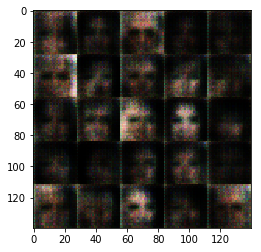

Epoch 1/1... Batches 225/1500... Discriminator Loss: 0.4095... Generator Loss: 2.8163
Epoch 1/1... Batches 250/1500... Discriminator Loss: 0.6069... Generator Loss: 1.8701
Epoch 1/1... Batches 275/1500... Discriminator Loss: 1.5049... Generator Loss: 4.4897
Epoch 1/1... Batches 300/1500... Discriminator Loss: 1.1128... Generator Loss: 0.6190


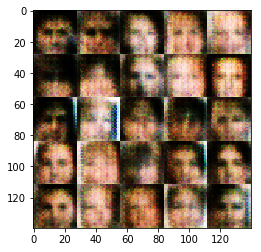

Epoch 1/1... Batches 325/1500... Discriminator Loss: 0.8656... Generator Loss: 1.6371
Epoch 1/1... Batches 350/1500... Discriminator Loss: 1.1606... Generator Loss: 0.6621
Epoch 1/1... Batches 375/1500... Discriminator Loss: 0.8782... Generator Loss: 0.9458
Epoch 1/1... Batches 400/1500... Discriminator Loss: 1.4946... Generator Loss: 2.5055


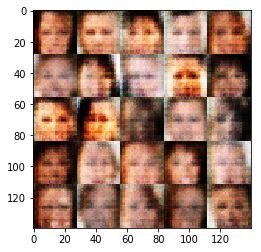

Epoch 1/1... Batches 425/1500... Discriminator Loss: 0.5953... Generator Loss: 1.8430
Epoch 1/1... Batches 450/1500... Discriminator Loss: 0.9204... Generator Loss: 1.3155
Epoch 1/1... Batches 475/1500... Discriminator Loss: 1.1843... Generator Loss: 0.8840
Epoch 1/1... Batches 500/1500... Discriminator Loss: 1.4624... Generator Loss: 0.3804


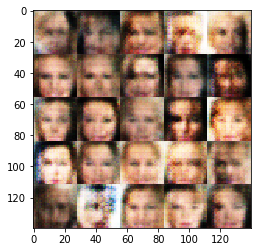

Epoch 1/1... Batches 525/1500... Discriminator Loss: 0.7523... Generator Loss: 1.3466
Epoch 1/1... Batches 550/1500... Discriminator Loss: 1.6100... Generator Loss: 0.3161
Epoch 1/1... Batches 575/1500... Discriminator Loss: 1.1233... Generator Loss: 1.1421
Epoch 1/1... Batches 600/1500... Discriminator Loss: 1.3063... Generator Loss: 0.5960


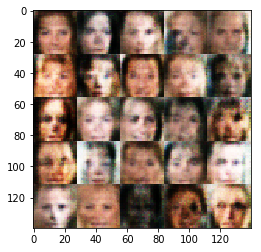

Epoch 1/1... Batches 625/1500... Discriminator Loss: 1.2548... Generator Loss: 1.7381
Epoch 1/1... Batches 650/1500... Discriminator Loss: 0.9074... Generator Loss: 1.7974
Epoch 1/1... Batches 675/1500... Discriminator Loss: 1.0666... Generator Loss: 0.9933
Epoch 1/1... Batches 700/1500... Discriminator Loss: 1.1597... Generator Loss: 0.6248


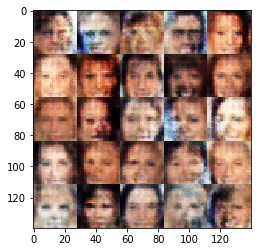

Epoch 1/1... Batches 725/1500... Discriminator Loss: 1.1487... Generator Loss: 0.6671
Epoch 1/1... Batches 750/1500... Discriminator Loss: 1.2898... Generator Loss: 0.5216
Epoch 1/1... Batches 775/1500... Discriminator Loss: 1.4276... Generator Loss: 0.3847
Epoch 1/1... Batches 800/1500... Discriminator Loss: 1.2392... Generator Loss: 0.5892


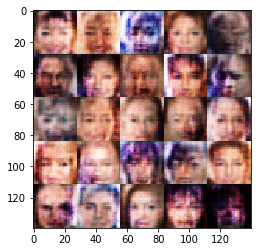

Epoch 1/1... Batches 825/1500... Discriminator Loss: 0.9022... Generator Loss: 1.4063
Epoch 1/1... Batches 850/1500... Discriminator Loss: 1.1369... Generator Loss: 0.7356
Epoch 1/1... Batches 875/1500... Discriminator Loss: 1.1810... Generator Loss: 0.6281
Epoch 1/1... Batches 900/1500... Discriminator Loss: 1.3299... Generator Loss: 0.5557


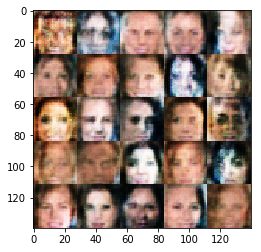

Epoch 1/1... Batches 925/1500... Discriminator Loss: 1.0934... Generator Loss: 0.6562
Epoch 1/1... Batches 950/1500... Discriminator Loss: 0.8947... Generator Loss: 1.0818
Epoch 1/1... Batches 975/1500... Discriminator Loss: 1.2210... Generator Loss: 0.5437
Epoch 1/1... Batches 1000/1500... Discriminator Loss: 1.0288... Generator Loss: 1.3705


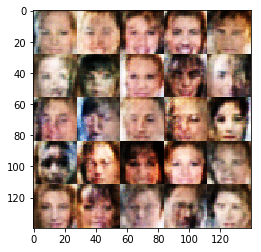

Epoch 1/1... Batches 1025/1500... Discriminator Loss: 1.0382... Generator Loss: 1.7734
Epoch 1/1... Batches 1050/1500... Discriminator Loss: 0.9630... Generator Loss: 0.9909
Epoch 1/1... Batches 1075/1500... Discriminator Loss: 0.9963... Generator Loss: 1.4088
Epoch 1/1... Batches 1100/1500... Discriminator Loss: 0.8980... Generator Loss: 1.2186


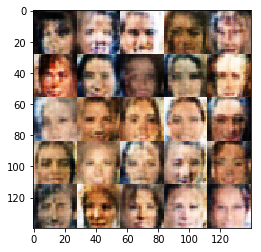

Epoch 1/1... Batches 1125/1500... Discriminator Loss: 0.9331... Generator Loss: 0.7573
Epoch 1/1... Batches 1150/1500... Discriminator Loss: 1.0077... Generator Loss: 0.7279
Epoch 1/1... Batches 1175/1500... Discriminator Loss: 1.0342... Generator Loss: 0.9262
Epoch 1/1... Batches 1200/1500... Discriminator Loss: 0.6838... Generator Loss: 1.0982


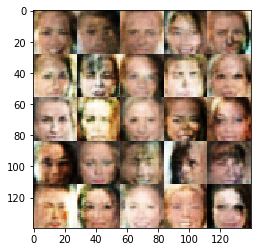

Epoch 1/1... Batches 1225/1500... Discriminator Loss: 1.0954... Generator Loss: 1.0760
Epoch 1/1... Batches 1250/1500... Discriminator Loss: 1.3303... Generator Loss: 1.2878
Epoch 1/1... Batches 1275/1500... Discriminator Loss: 1.0386... Generator Loss: 0.7016
Epoch 1/1... Batches 1300/1500... Discriminator Loss: 1.0082... Generator Loss: 0.8588


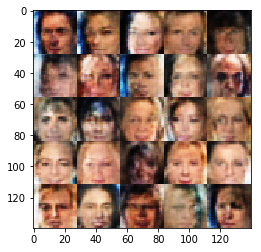

Epoch 1/1... Batches 1325/1500... Discriminator Loss: 0.8956... Generator Loss: 0.9051
Epoch 1/1... Batches 1350/1500... Discriminator Loss: 0.9400... Generator Loss: 1.1659
Epoch 1/1... Batches 1375/1500... Discriminator Loss: 1.0789... Generator Loss: 0.7087
Epoch 1/1... Batches 1400/1500... Discriminator Loss: 0.8174... Generator Loss: 1.2675


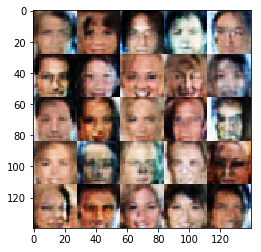

Epoch 1/1... Batches 1425/1500... Discriminator Loss: 1.0001... Generator Loss: 0.6557
Epoch 1/1... Batches 1450/1500... Discriminator Loss: 0.7205... Generator Loss: 1.4882
Epoch 1/1... Batches 1475/1500... Discriminator Loss: 1.2000... Generator Loss: 1.7897
Epoch 1/1... Batches 1500/1500... Discriminator Loss: 0.8534... Generator Loss: 1.1359


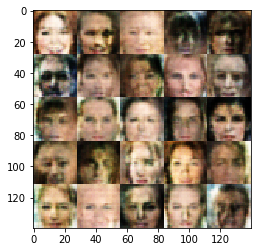

Epoch 1/1... Batches 1525/1500... Discriminator Loss: 0.6658... Generator Loss: 1.0059
Epoch 1/1... Batches 1550/1500... Discriminator Loss: 0.6272... Generator Loss: 1.6122
Epoch 1/1... Batches 1575/1500... Discriminator Loss: 0.8687... Generator Loss: 1.1831
Epoch 1/1... Batches 1600/1500... Discriminator Loss: 0.7065... Generator Loss: 1.1996


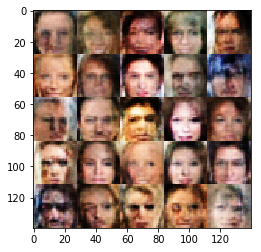

Epoch 1/1... Batches 1625/1500... Discriminator Loss: 0.7171... Generator Loss: 1.4569
Epoch 1/1... Batches 1650/1500... Discriminator Loss: 1.2056... Generator Loss: 0.7202
Epoch 1/1... Batches 1675/1500... Discriminator Loss: 0.8950... Generator Loss: 0.8446
Epoch 1/1... Batches 1700/1500... Discriminator Loss: 1.1368... Generator Loss: 0.6146


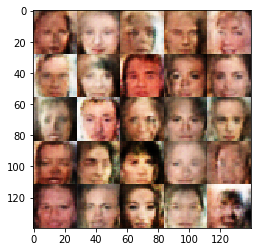

Epoch 1/1... Batches 1725/1500... Discriminator Loss: 0.8306... Generator Loss: 1.7546
Epoch 1/1... Batches 1750/1500... Discriminator Loss: 0.9292... Generator Loss: 1.1558
Epoch 1/1... Batches 1775/1500... Discriminator Loss: 1.1386... Generator Loss: 1.5670
Epoch 1/1... Batches 1800/1500... Discriminator Loss: 1.0625... Generator Loss: 0.9916


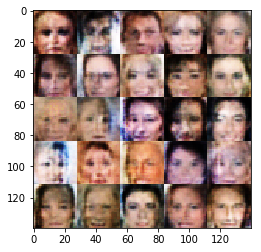

Epoch 1/1... Batches 1825/1500... Discriminator Loss: 1.2015... Generator Loss: 0.4879
Epoch 1/1... Batches 1850/1500... Discriminator Loss: 1.0261... Generator Loss: 0.6822
Epoch 1/1... Batches 1875/1500... Discriminator Loss: 0.8479... Generator Loss: 1.5833
Epoch 1/1... Batches 1900/1500... Discriminator Loss: 0.9995... Generator Loss: 0.6280


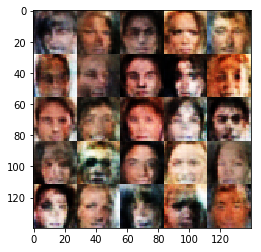

Epoch 1/1... Batches 1925/1500... Discriminator Loss: 1.0439... Generator Loss: 1.0535
Epoch 1/1... Batches 1950/1500... Discriminator Loss: 1.0031... Generator Loss: 0.7272
Epoch 1/1... Batches 1975/1500... Discriminator Loss: 0.9630... Generator Loss: 0.8066
Epoch 1/1... Batches 2000/1500... Discriminator Loss: 0.9828... Generator Loss: 1.5004


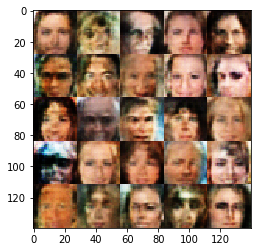

Epoch 1/1... Batches 2025/1500... Discriminator Loss: 0.9018... Generator Loss: 0.7749
Epoch 1/1... Batches 2050/1500... Discriminator Loss: 0.9892... Generator Loss: 1.1727
Epoch 1/1... Batches 2075/1500... Discriminator Loss: 0.9634... Generator Loss: 0.9281
Epoch 1/1... Batches 2100/1500... Discriminator Loss: 1.4043... Generator Loss: 0.4642


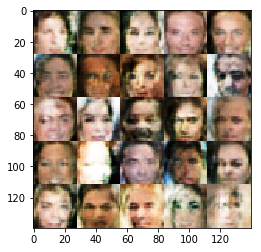

Epoch 1/1... Batches 2125/1500... Discriminator Loss: 0.8830... Generator Loss: 1.6592


In [ ]:
batch_size = 40
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.